# Mapping and unsupervised clustering analysis for NI tests (Part 2)

### Requirements and dependencies

In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('..','..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from kneed import KneeLocator

from Mapping import plot_pdf_with_deconvolution_on_axis
from Mapping import plot_cdf_with_weibull_fit_on_axis
from Mapping import plot_clustered_data
from Mapping import plot_map
from Mapping import plot_pixel_map

# Graphics settings
xDim = 4
yDim = 2
cMap = 'viridis'

### Specimen informations + Results path

In [2]:
# Sample 1
sampleNames = ['Ni_SiC']
file_paths = [Path(r"C:\Users\dmercier\OneDrive - ANSYS, Inc\Documents\GitHub\Indentation2025\Atelier1_ML-Clustering\Dataset\Ni_SiC\MTS_example1_25x25.xls")]
sheet_name = 'Sample'

# Sample 2
# sampleNames = ['HSS-Steel_Carbides']
# file_paths = [Path(r"C:\Users\dmercier\OneDrive - ANSYS, Inc\Documents\GitHub\Indentation2025\Atelier1_ML-Clustering\Dataset\HSS_Steel_Carbides\MTS_example1_25x25_flower.xls")]
# sheet_name = 'Sample'

# Sample 3
# sampleNames = ['Al6061_T6_Al2O3']
# file_paths = [Path(r"C:\Users\dmercier\OneDrive - ANSYS, Inc\Documents\GitHub\Indentation2025\Atelier1_ML-Clustering\Dataset\Al6061_T6_Al2O3\MTS_example1_25x25_flower.xls")]
# sheet_name = 'Sample'

# Result directory
result_dir = Path(r"C:\Users\dmercier\OneDrive - ANSYS, Inc\Documents\GitHub\Indentation2025\Atelier1_ML-Clustering\Results\3D_Clustering")
# Create the directory if it doesn't exist
result_dir.mkdir(parents=True, exist_ok=True)


### Loading dataset and make mechanical properties dataframe

In [3]:
# Import data from Excel files
data_frames = []
for file_path in file_paths:
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    data_frames.append(df)
data = pd.concat(data_frames, ignore_index=True)

# Merge first row (containing units) with the header
data.columns = [f"{col}_{unit}" if unit else col for col, unit in zip(data.columns, data.iloc[0])]
data = data.drop(index=0).reset_index(drop=True)
data = data.apply(pd.to_numeric, errors='ignore')

# Replace empty strings with NaN
data.replace("", np.nan, inplace=True)

# Remove colums Markers and Index Integer
data.drop(columns=[col for col in data.columns if 'Markers_nan' in col or 'Index_Integer' in col], inplace=True)

print(data.head())

# Save as a .csv file
data.to_csv(result_dir / 'imported_data.csv', index=False)
print(f"Data saved to {result_dir / 'imported_data.csv'}")

   X Position_µm  Y Position_µm  HARDNESS_GPa  MODULUS_GPa
0              0              0          6.58        268.2
1              2              0          4.76        177.3
2              4              0          4.42        233.3
3              6              0          0.15          4.0
4              8              0          5.00        223.6
Data saved to C:\Users\dmercier\OneDrive - ANSYS, Inc\Documents\GitHub\Indentation2025\Atelier1_ML-Clustering\Results\3D_Clustering\imported_data.csv


C:\Users\dmercier\AppData\Local\Temp\ipykernel_37200\2725171850.py:11: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data = data.apply(pd.to_numeric, errors='ignore')


### Mapping analysis

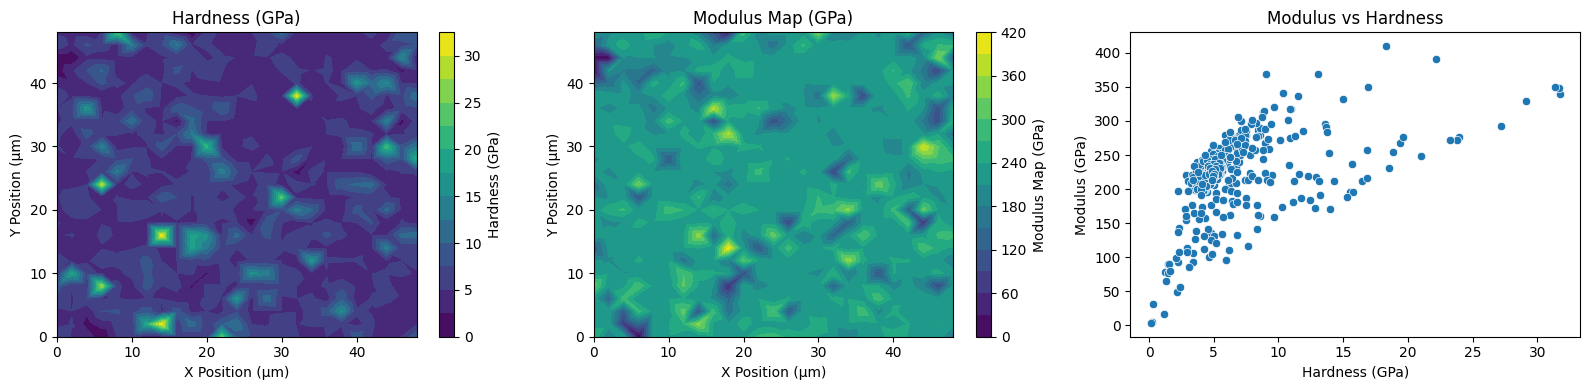

c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mo

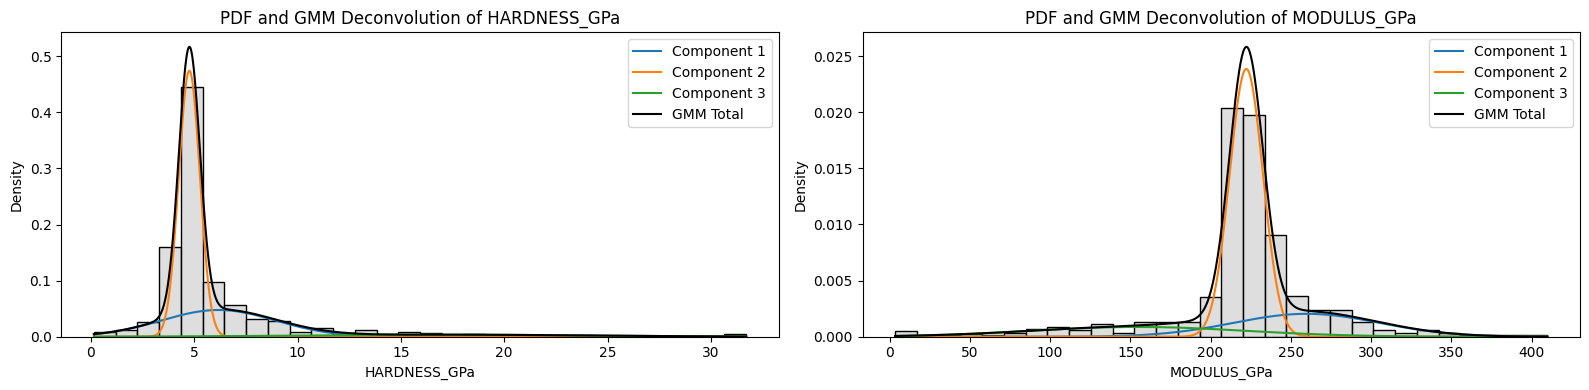

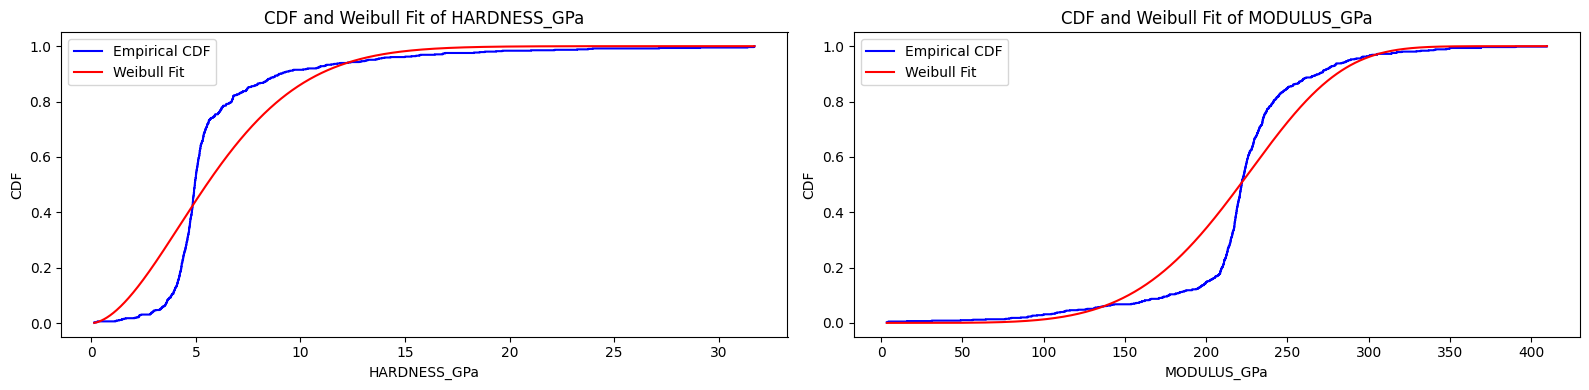

In [4]:
# Create a 1x3 subplot layout
fig, axes = plt.subplots(1, 3, figsize=(4*xDim, 2*yDim))

# Plot Hardness map
plot_map(data['X Position_µm'], data['Y Position_µm'], data['HARDNESS_GPa'], 
         title='Hardness (GPa)', xlabel='X Position (µm)', ylabel='Y Position (µm)', 
         ax=axes[0])  # Pass the first subplot axis

# Plot Modulus map
plot_map(data['X Position_µm'], data['Y Position_µm'], data['MODULUS_GPa'], 
         title='Modulus Map (GPa)', xlabel='X Position (µm)', ylabel='Y Position (µm)', 
         ax=axes[1])  # Pass the second subplot axis

# Plot Modulus vs Hardness
sns.scatterplot(y='MODULUS_GPa', x='HARDNESS_GPa', data=data, ax=axes[2])  # Pass the third subplot axis
axes[2].set_title('Modulus vs Hardness')
axes[2].set_ylabel('Modulus (GPa)')
axes[2].set_xlabel('Hardness (GPa)')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(result_dir / 'maps_scatter.png')
plt.show()

# Create a 1x2 subplot layout
fig, axes = plt.subplots(1, 2, figsize=(4*xDim, 2*yDim))

n_componentsVal = 3  # Adjust based on expected number of phases

# Plot PDF and GMM Deconvolution for Hardness
plot_pdf_with_deconvolution_on_axis(data, 'HARDNESS_GPa', n_components=n_componentsVal, ax=axes[0])
# Plot PDF and GMM Deconvolution for Modulus
plot_pdf_with_deconvolution_on_axis(data, 'MODULUS_GPa', n_components=n_componentsVal, ax=axes[1])

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(result_dir / 'pdf_gmm_deconvolution.png')
plt.show()

# Create a 1x2 subplot layout
fig, axes = plt.subplots(1, 2, figsize=(4*xDim, 2*yDim))

# Plot CDF and Weibull fit for Hardness
plot_cdf_with_weibull_fit_on_axis(data, 'HARDNESS_GPa', ax=axes[0])
# Plot CDF and Weibull fit for Modulus
plot_cdf_with_weibull_fit_on_axis(data, 'MODULUS_GPa', ax=axes[1])

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(result_dir / 'cdf_weibull_fit.png')
plt.show()

### Adding KAMM values

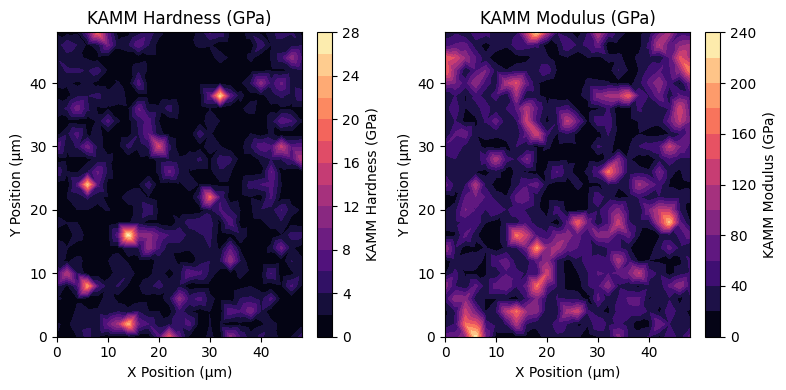

In [5]:
# Calculation of KAMM parameter
order = 1  # 1 for first order, 2 for second order

# Define neighbor offsets based on order
if order == 1:
    neighbor_offsets = [(0,1), (0,-1), (1,0), (-1,0)]
elif order == 2:
    neighbor_offsets = [(-2,0), (2,0), (0,-2), (0,2),
                        (-1,-1), (-1,1), (1,-1), (1,1)]
else:
    raise ValueError("order must be 1 or 2")

def compute_kam_metric_diff(grid, dataframe, name):
    
    # Initialize KAM array
    kam = np.full(grid.shape, np.nan, dtype=float)
    rows, cols = kam.shape

    # Loop over each cell to compute neighbor differences
    for i in range(rows):
        for j in range(cols):
            if np.isnan(grid[i, j]):
                continue
            center_val = grid[i, j]
            diffs = []
            for di, dj in neighbor_offsets:
                ni, nj = i + di, j + dj
                if 0 <= ni < rows and 0 <= nj < cols and not np.isnan(grid[ni, nj]):
                    diffs.append(abs(grid[ni, nj] - center_val))
            if diffs:
                kam[i, j] = np.mean(diffs)

    # Flatten KAM array and add to dataframe
    dataframe[name] = kam.flatten()
    return dataframe

# Plot KAMM map
# Reshape data into a grid
grid_size = int(np.sqrt(len(data)))  # Assuming square grid
hardness_grid = data['HARDNESS_GPa'].values.reshape((grid_size, grid_size))
data = compute_kam_metric_diff(hardness_grid, data, 'KAMM_HARDNESS_GPa')
modulus_grid = data['MODULUS_GPa'].values.reshape((grid_size, grid_size))
data = compute_kam_metric_diff(modulus_grid, data, 'KAMM_MODULUS_GPa')

# Create a 1x2 subplot layout
fig, axes = plt.subplots(1, 2, figsize=(2*xDim, 2*yDim))
# Plot KAMM for Hardness
plot_map(data['X Position_µm'], data['Y Position_µm'], data['KAMM_HARDNESS_GPa'], 
         title='KAMM Hardness (GPa)', xlabel='X Position (µm)', ylabel='Y Position (µm)', 
         ax=axes[0], cmap='magma')  # Pass the first subplot axis
# Plot KAMM for Modulus
plot_map(data['X Position_µm'], data['Y Position_µm'], data['KAMM_MODULUS_GPa'], 
         title='KAMM Modulus (GPa)', xlabel='X Position (µm)', ylabel='Y Position (µm)', 
         ax=axes[1], cmap='magma')  # Pass the second subplot axis
# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(result_dir / 'kamm_maps.png')
plt.show()


### Matrix correlation analysis

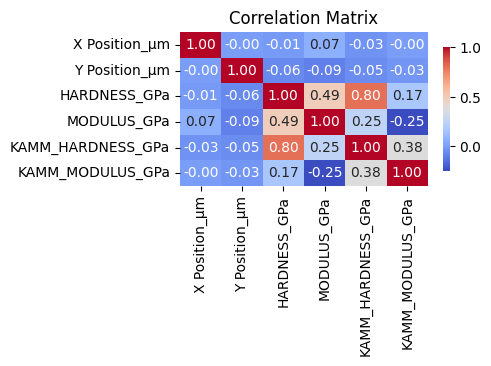

In [6]:
# Plot matrix correlation
plt.figure(figsize=(xDim, yDim))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.savefig(result_dir / 'correlation_matrix.png')
plt.show()

### Clustering analysis - Number of clusters estimation

c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\

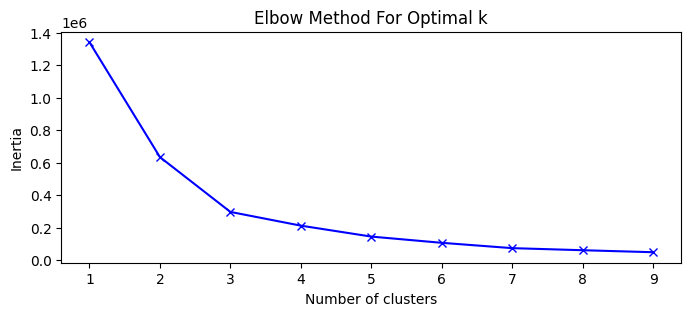

Optimal number of clusters: 3


In [7]:
# Cluster the data using KMeans, or GMM...
method = 'KMeans'
#method = 'GMM'
# ... DBSCAN ?

if method == 'KMeans':
    # Determine optimal number of clusters using Elbow Method
    inertia = []
    K = range(1, 10)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data[['HARDNESS_GPa', 'MODULUS_GPa']].dropna())
        inertia.append(kmeans.inertia_)

    # Plot the Elbow Method
    plt.figure(figsize=(2*xDim, 1.5*yDim))
    plt.plot(K, inertia, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.savefig(result_dir / 'elbow_method.png')
    plt.show()

    # Find the optimal number of clusters using KneeLocator
    knee_locator = KneeLocator(K, inertia, curve="convex", direction="decreasing")
    optimal_k = knee_locator.knee

elif method == 'GMM':
    # Determine optimal number of clusters using BIC
    bics = []
    K = range(1, 10)
    for k in K:
        gmm = GaussianMixture(n_components=k, random_state=42)
        gmm.fit(data[['HARDNESS_GPa', 'MODULUS_GPa']].dropna())
        bics.append(gmm.bic(data[['HARDNESS_GPa', 'MODULUS_GPa']].dropna()))

    # Plot the BIC
    plt.figure(figsize=(2*xDim, 1.5*yDim))
    plt.plot(K, bics, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('BIC')
    plt.title('BIC For Optimal k')
    plt.savefig(result_dir / 'bic_method.png')
    plt.show()

    # Find the optimal number of clusters using KneeLocator
    knee_locator = KneeLocator(K, bics, curve="convex", direction="increasing")
    optimal_k = knee_locator.knee
    
print(f"Optimal number of clusters: {optimal_k}")
#optimal_k = 3  # Manually set for demonstration purposes

# Define colors for clusters
colors = sns.color_palette('tab10', n_colors=optimal_k)
cmap = {i: colors[i] for i in range(optimal_k)}

### Principle component analysis (PCA)

In [12]:
# Investigate Principle Component Analysis (PCA)
# scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
features = ['HARDNESS_GPa', 'MODULUS_GPa', 'KAMM_HARDNESS_GPa', 'KAMM_MODULUS_GPa']
x = StandardScaler().fit_transform(data[features])
# Apply PCA --> reducing the dimensionality for visualization purposes
pca = PCA(n_components=2)
# Replace NaN values with the mean of each column
x = np.nan_to_num(x, nan=np.nanmean(x, axis=0))
principal_components = pca.fit_transform(x)
pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
# Add cluster labels to the PCA dataframe
if method == 'KMeans':
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    pc_df['Cluster'] = kmeans.fit_predict(data[['HARDNESS_GPa', 'MODULUS_GPa']].fillna(method='ffill').fillna(method='bfill'))
elif method == 'GMM':
    gmm = GaussianMixture(n_components=optimal_k, random_state=42)
    pc_df['Cluster'] = gmm.fit_predict(data[['HARDNESS_GPa', 'MODULUS_GPa']].fillna(method='ffill').fillna(method='bfill'))

# Plot PCA results
plot_clustered_data(pc_df, 'PC1', 'PC2', 'Cluster',        
                    colors, result_dir, xDim, yDim, 
                    'PCA of Hardness and Modulus', 'Principal Component 1', 'Principal Component 2')

# Plot the corresponding phase map
plot_pixel_map(data['X Position_µm'], data['Y Position_µm'], pc_df['Cluster'], 
               title='Phase Map from PCA Clusters', xlabel='X Position (µm)', ylabel='Y Position (µm)',
               xDim=xDim, yDim=yDim,
               cluster_colors=cmap, save_path=result_dir / 'spatial_clusters_pca.png')


ValueError: Shape of passed values is (625, 4), indices imply (625, 2)

### Clustering analysis - K-means clustering

c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Pixel map plot saved to C:\Users\dmercier\OneDrive - ANSYS, Inc\Documents\GitHub\Indentation2025\Atelier1_ML-Clustering\Results\3D_Clustering\spatial_clusters.png


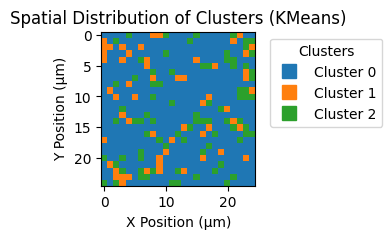

In [9]:
# Perform clustering based on PCA components
if method == 'KMeans':
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    data['Cluster'] = kmeans.fit_predict(data[['HARDNESS_GPa', 'MODULUS_GPa', 'KAMM_HARDNESS_GPa', 'KAMM_MODULUS_GPa']].fillna(0))
elif method == 'GMM':
    gmm = GaussianMixture(n_components=optimal_k, random_state=42)
    data['Cluster'] = gmm.fit_predict(data[['HARDNESS_GPa', 'MODULUS_GPa', 'KAMM_HARDNESS_GPa', 'KAMM_MODULUS_GPa']].fillna(0))
else:
    raise ValueError("Unsupported clustering method")

# Plot clusters on spatial map with square pixels
plot_pixel_map(data['X Position_µm'], data['Y Position_µm'], data['Cluster'], 
               title=f'Spatial Distribution of Clusters ({method})', 
               xlabel='X Position (µm)', ylabel='Y Position (µm)',
               xDim=xDim, yDim=yDim,
               cluster_colors=colors, save_path=result_dir / 'spatial_clusters.png')


c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Pixel map plot saved to C:\Users\dmercier\OneDrive - ANSYS, Inc\Documents\GitHub\Indentation2025\Atelier1_ML-Clustering\Results\3D_Clustering\spatial_3d_clusters.png


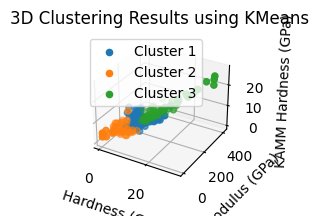

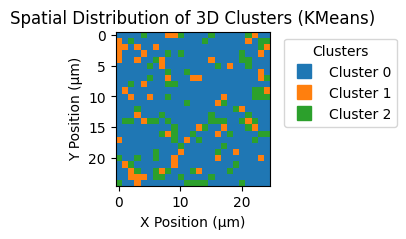

In [10]:
# Perform 3D clustering based on hardness, modulus, and KAMM hardness
if method == 'KMeans':
    kmeans_3d = KMeans(n_clusters=optimal_k, random_state=42)
    data['Cluster_3D'] = kmeans_3d.fit_predict(data[['HARDNESS_GPa', 'MODULUS_GPa', 'KAMM_HARDNESS_GPa']].fillna(0))
elif method == 'GMM':
    gmm_3d = GaussianMixture(n_components=optimal_k, random_state=42)
    data['Cluster_3D'] = gmm_3d.fit_predict(data[['HARDNESS_GPa', 'MODULUS_GPa', 'KAMM_HARDNESS_GPa']].fillna(0))
else:
    raise ValueError("Unsupported clustering method")

# Plot clustering results in 3D space
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(xDim, yDim))
ax = fig.add_subplot(111, projection='3d')
for cluster in range(optimal_k):
    cluster_data = data[data['Cluster_3D'] == cluster]
    ax.scatter(cluster_data['HARDNESS_GPa'], cluster_data['MODULUS_GPa'], cluster_data['KAMM_HARDNESS_GPa'], 
               label=f'Cluster {cluster+1}', color=colors[cluster])
ax.set_title(f'3D Clustering Results using {method}')
ax.set_xlabel('Hardness (GPa)')
ax.set_ylabel('Modulus (GPa)')
ax.set_zlabel('KAMM Hardness (GPa)')
ax.legend()
plt.savefig(result_dir / '3d_clustering.png')

plot_pixel_map(data['X Position_µm'], data['Y Position_µm'], data['Cluster_3D'], 
               title=f'Spatial Distribution of 3D Clusters ({method})', 
               xlabel='X Position (µm)', ylabel='Y Position (µm)',
               xDim=xDim, yDim=yDim,
               cluster_colors=colors, save_path=result_dir / 'spatial_3d_clusters.png')

### All plots

c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
C:\Users\dmercier\AppData\Local\Temp\ipykernel_37200\3876730443.py:63: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(data['MODULUS_GPa'], ax=axes[1, 1], fi

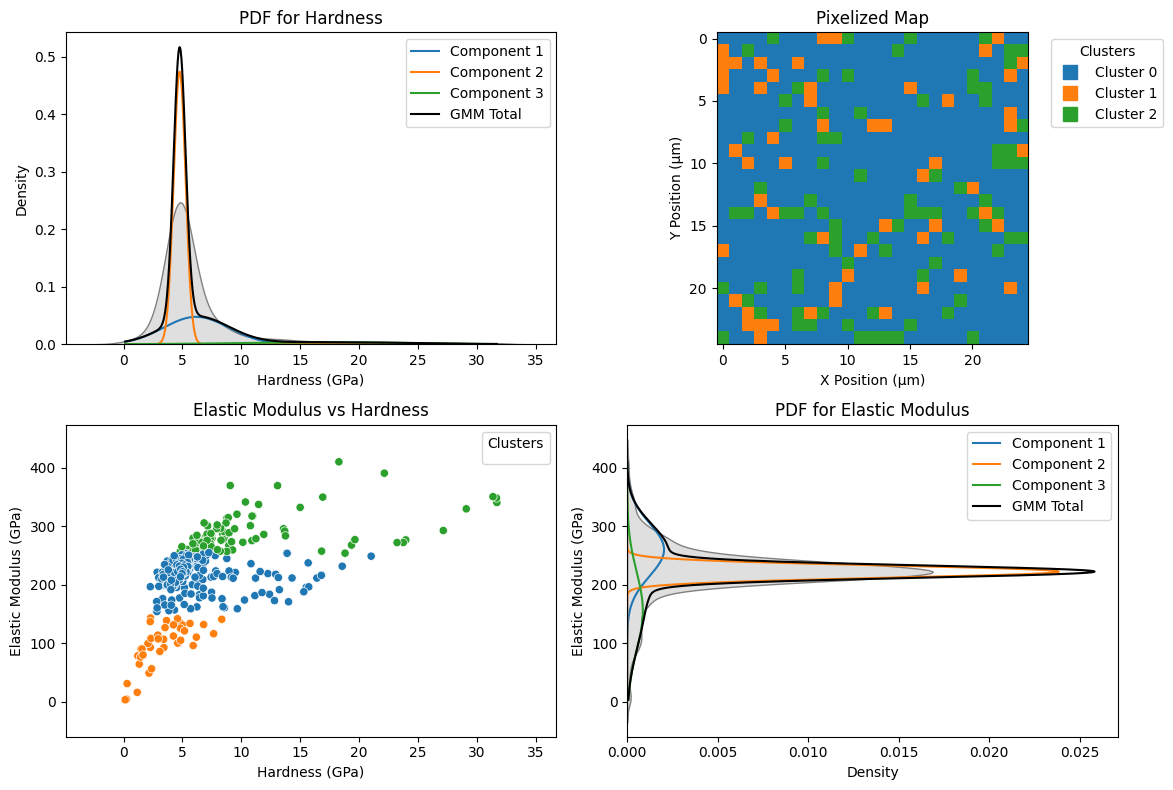

In [11]:
# Define the number of clusters
optimal_k = len(data['Cluster_3D'].unique())

# Define colors for clusters
colors = sns.color_palette('tab10', n_colors=optimal_k)
cluster_cmap = ListedColormap(colors)

# Pivot data for pixelized map (handle duplicates by aggregating with pivot_table)
grid_data = data.pivot_table(
    index='Y Position_µm',
    columns='X Position_µm',
    values='Cluster_3D',
    aggfunc='mean'  # You can use 'mean', 'median', or another aggregation function
)
grid_data = grid_data.sort_index(ascending=False)  # Ensure proper orientation

# Create the 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(3*xDim, 4*yDim))

# Top Left: PDF for Hardness
sns.kdeplot(data['HARDNESS_GPa'], ax=axes[0, 0], fill=True, color='gray')
axes[0, 0].set_title('PDF for Hardness')
axes[0, 0].set_xlabel('Hardness (GPa)')
axes[0, 0].set_ylabel('Density')
# Add Deconvolution with peaks with same colors as corresponding clusters
n_componentsVal = optimal_k  # Use the optimal number of clusters determined earlier
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=n_componentsVal, random_state=0)
gmm.fit(data[['HARDNESS_GPa']].dropna())
x = np.linspace(data['HARDNESS_GPa'].min(), data['HARDNESS_GPa'].max(), 1000).reshape(-1, 1)
logprob = gmm.score_samples(x)
responsibilities = gmm.predict_proba(x)
pdf = np.exp(logprob)
for i in range(n_componentsVal):
    axes[0, 0].plot(x, responsibilities[:, i] * pdf, label=f'Component {i+1}', color=colors[i])
axes[0, 0].plot(x, pdf, '-k', label='GMM Total')
axes[0, 0].legend()

# Top Right: Pixelized Map
im = axes[0, 1].imshow(grid_data, cmap=cluster_cmap, aspect='equal', interpolation='none')
axes[0, 1].set_title('Pixelized Map')
axes[0, 1].set_xlabel('X Position (µm)')
axes[0, 1].set_ylabel('Y Position (µm)')

# Create discrete legend handles for clusters
unique_clusters = np.unique(grid_data[~np.isnan(grid_data)])  # Exclude NaN values
handles = [
    plt.Line2D(
        [0], [0], 
        marker='s', 
        color=cluster_cmap(cluster / len(unique_clusters)), 
        linestyle='', 
        markersize=10, 
        label=f'Cluster {int(cluster)}'
    ) 
    for cluster in unique_clusters if not np.isnan(cluster)  # Ensure cluster is not NaN
]

# Add the discrete legend
axes[0, 1].legend(handles=handles, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

# Bottom Right: PDF for Elastic Modulus rotated 90°
sns.kdeplot(data['MODULUS_GPa'], ax=axes[1, 1], fill=True, color='gray', vertical=True)
axes[1, 1].set_title('PDF for Elastic Modulus')
axes[1, 1].set_xlabel('Density')
axes[1, 1].set_ylabel('Elastic Modulus (GPa)')
# Add Deconvolution with peaks with same colors as corresponding clusters
gmm = GaussianMixture(n_components=n_componentsVal, random_state=0)
gmm.fit(data[['MODULUS_GPa']].dropna())
x = np.linspace(data['MODULUS_GPa'].min(), data['MODULUS_GPa'].max(), 1000).reshape(-1, 1)
logprob = gmm.score_samples(x)
responsibilities = gmm.predict_proba(x)
pdf = np.exp(logprob)
for i in range(n_componentsVal):
    axes[1, 1].plot(responsibilities[:, i] * pdf, x, label=f'Component {i+1}', color=colors[i])
axes[1, 1].plot(pdf, x, '-k', label='GMM Total')
axes[1, 1].legend()

# Bottom Left: Elastic Modulus vs Hardness with same axis scale than PDFs plots
sns.scatterplot(y='MODULUS_GPa', x='HARDNESS_GPa', data=data, ax=axes[1, 0], hue='Cluster_3D', palette=colors, legend=False)
axes[1, 0].set_title('Elastic Modulus vs Hardness')
axes[1, 0].set_ylabel('Elastic Modulus (GPa)')
axes[1, 0].set_xlabel('Hardness (GPa)')
axes[1, 0].set_xlim(axes[0, 0].get_xlim())
axes[1, 0].set_ylim(axes[1, 1].get_ylim())
axes[1, 0].legend(title='Clusters')

# Adjust layout
plt.tight_layout()
plt.show()